In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import nltk
from nltk.corpus import stopwords
from collections import Counter
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("twitter_data.csv") 
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year != 2017]
df.sample(15)

,content,date,username,sector,Sentiment
62192,The billionaires behind two of India's biggest...,2020-11-03,BloombergNRG,Energy,positive
29471,Apollo CEO Marc Rowan says crypto and blockcha...,2022-04-24,crypto,Crypto,neutral
74635,Russia shrugs off Germany’s Nord Stream 2 sanc...,2022-02-23,ftenergy,Energy,neutral
35933,The Winklevoss twins have seen their wealth mo...,2019-06-26,crypto,Crypto,positive
13672,Secret oil shipments could help Iran cushion U...,2018-09-02,BNCommodities,Commodities,positive
113838,Apple suspends listening to Siri commands afte...,2019-08-22,technology,Technology,neutral
106,EU policymakers agreed to raise €20 billion ($...,2022-12-13,BNCommodities,Commodities,positive
111109,Monday will be the first chance for insiders t...,2019-12-06,technology,Technology,neutral
10770,"Luckily for China’s cows, the country is remov...",2019-09-11,BNCommodities,Commodities,neutral
95165,Figma is shaking up the design world with its ...,2021-06-24,technology,Technology,neutral


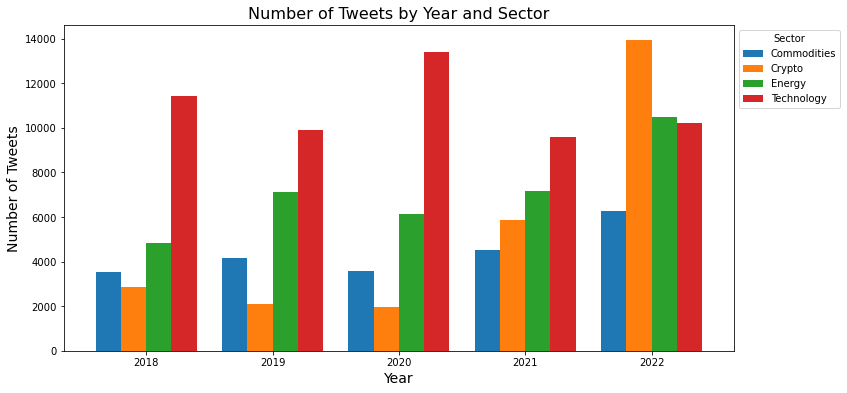

sector  Commodities  Crypto  Energy  Technology
year                                           
2018           3526    2840    4828       11448
2019           4162    2078    7120        9908
2020           3564    1952    6150       13402
2021           4538    5884    7182        9597
2022           6279   13930   10469       10229


In [3]:
# Graph
df['year'] = df['date'].dt.year

fig, ax = plt.subplots(figsize=(12,6))

df.groupby(['year', 'sector']).size().unstack().plot(kind='bar', ax=ax, width=0.8)

ax.set_title('Number of Tweets by Year and Sector', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Tweets', fontsize=14)

plt.xticks(rotation=0)
plt.legend(title='Sector', bbox_to_anchor=(1.0, 1.0))
plt.show();

#Table
table = pd.pivot_table(df, values='content', index='year', columns='sector', aggfunc=len, fill_value=0)
print(table)

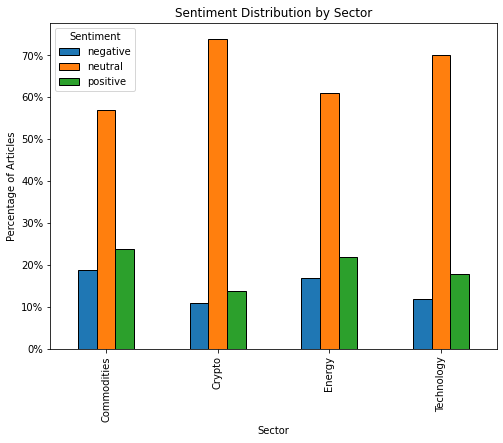

Sentiment,negative,neutral,positive
sector,,,
Commodities,19.00%,57.00%,24.00%
Crypto,11.00%,74.00%,14.00%
Energy,17.00%,61.00%,22.00%
Technology,12.00%,70.00%,18.00%


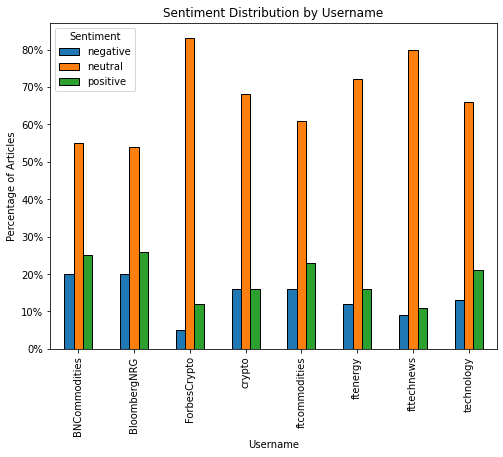

Sentiment,negative,neutral,positive
username,,,
BNCommodities,20.00%,55.00%,25.00%
BloombergNRG,20.00%,54.00%,26.00%
ForbesCrypto,5.00%,83.00%,12.00%
crypto,16.00%,68.00%,16.00%
ftcommodities,16.00%,61.00%,23.00%
ftenergy,12.00%,72.00%,16.00%
fttechnews,9.00%,80.00%,11.00%
technology,13.00%,66.00%,21.00%


In [4]:
group_columns = [['sector', 'Sentiment'], ['username', 'Sentiment']]
for columns in group_columns:
    col1, col2 = columns
    grouped = df.groupby(columns).size().unstack()
    grouped_norm = grouped.div(grouped.sum(axis=1), axis=0)
    grouped_norm = grouped_norm.round(2)

    fig, ax = plt.subplots(figsize=(8, 6))
    grouped_norm.plot(kind='bar', ax=ax, edgecolor='black')

    ax.set_title('Sentiment Distribution by {}'.format(col1.capitalize()))
    ax.set_xlabel(col1.capitalize())
    ax.set_ylabel('Percentage of Articles')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.show()

    display(grouped_norm.applymap(lambda x: '{:.2f}%'.format(x * 100)))
    

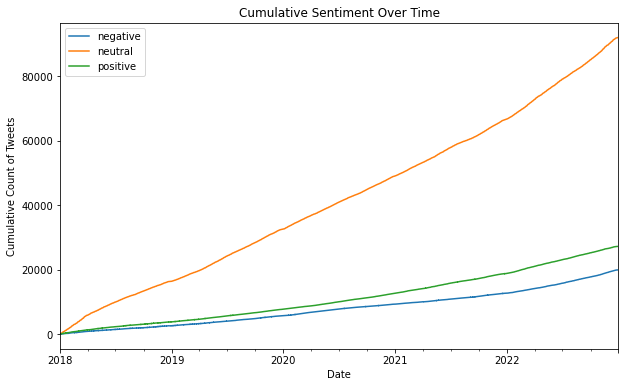

In [5]:
grouped = df.groupby(['date', 'Sentiment']).size().reset_index(name='count')
pivoted = grouped.pivot(index='date', columns='Sentiment', values='count')
cumulative = pivoted.cumsum()

fig, ax = plt.subplots(figsize=(10, 6))

for sentiment in ['negative', 'neutral', 'positive']:
    cumulative[sentiment].plot(ax=ax, label=sentiment)

ax.set_title('Cumulative Sentiment Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Count of Tweets')
ax.legend()

plt.show()


In [6]:
def process_text(df, sentiment, top_n, neutral_words):
    stop_words = set(stopwords.words("english"))
    subset = df[df["Sentiment"] == sentiment]
    cleaned_text = subset["content"].apply(lambda x: " ".join([word.lower() for word in nltk.word_tokenize(x) if word.isalpha() and word.lower() not in stop_words]))
    tokenized_text = " ".join(cleaned_text).split()
    word_counts = Counter(tokenized_text)
    top_words = [word for word, count in word_counts.most_common() if word not in neutral_words and word not in stop_words][:top_n]
    return top_words

subset = df[df["Sentiment"] == 'neutral']
neutral_words = process_text(subset, "neutral", 100, [])

sentiments = ["positive", "negative"]
top_n = 10
for sentiment in sentiments:
    sentiment_words = process_text(df, sentiment, top_n, neutral_words)

    print(f"Top {top_n} {sentiment} words:")
    for word in sentiment_words:
        print(word)
    print()


Top 10 positive words:
demand
record
boost
production
supply
high
surge
since
shares
natural

Top 10 negative words:
demand
cut
supply
hit
shares
production
since
cuts
crisis
according



In [7]:
def process_data(price_file, twitter_file):
    def load_and_filter(df_file):
        df = pd.read_csv(df_file).rename(columns={'Date': 'date'})
        df['date'] = pd.to_datetime(df['date'])
        return df[df['date'].dt.year != 2017]   
    df_price, df_twitter = load_and_filter(price_file), load_and_filter(twitter_file)
    
    df_price['PriceChange'] = df_price['Close'] - df_price['Open']
    df_price = df_price.sort_values('date')
    df_price['NextDayPriceChange'] = df_price.groupby('sector')['PriceChange'].shift(-1)
    df_twitter['SentimentScore'] = df_twitter['Sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
    return pd.merge(df_price, df_twitter, on=['date', 'sector'], how='inner')

df_merged = process_data('Price_Data.csv', 'twitter_data.csv')

In [8]:
df_grouped = df_merged.groupby(['date', 'sector']).agg({'NextDayPriceChange': 'mean', 'SentimentScore': 'mean'}).reset_index()

correlation, p_value = pearsonr(df_grouped['NextDayPriceChange'], df_grouped['SentimentScore'])
print("Correlation between NextDayPriceChange and SentimentScore:", correlation)
print("p-value:", p_value)

Correlation between NextDayPriceChange and SentimentScore: 0.05005890434541705
p-value: 0.000876820164179016


In [9]:
df_grouped = df_merged.groupby(['date', 'sector']).agg({'NextDayPriceChange': 'mean', 'SentimentScore': 'mean'}).reset_index()
correlations_and_pvalues = df_grouped.groupby('sector').apply(lambda x: stats.pearsonr(x['NextDayPriceChange'], x['SentimentScore']))

for sector, corr_pval in correlations_and_pvalues.items():
    print(f"Correlation and p-value for {sector} Sector: {corr_pval[0]:.2f}, {corr_pval[1]:.5f}")

Correlation and p-value for Commodities Sector: 0.03, 0.38338
Correlation and p-value for Crypto Sector: 0.07, 0.00779
Correlation and p-value for Energy Sector: 0.10, 0.00195
Correlation and p-value for Technology Sector: -0.02, 0.52939


In [10]:
sectors = ['Energy', 'Commodities', 'Technology']

for sector in sectors:
    df_sector = df_merged[df_merged['sector'] == sector]
    df_sector_grouped = df_sector.groupby(['date', 'sector', 'ListSize']).agg({'NextDayPriceChange': 'mean', 'SentimentScore': 'mean'}).reset_index()
    correlations_listsize = df_sector_grouped.groupby('ListSize').apply(lambda x: x['NextDayPriceChange'].corr(x['SentimentScore'], method='pearson'))

    print(f"Correlations between NextDayPriceChange and SentimentScore for the '{sector}' sector across different 'listsizes':")
    print(correlations_listsize)
    

Correlations between NextDayPriceChange and SentimentScore for the 'Energy' sector across different 'listsizes':
ListSize
Large    0.108188
Mid      0.093536
Small    0.053263
dtype: float64
Correlations between NextDayPriceChange and SentimentScore for the 'Commodities' sector across different 'listsizes':
ListSize
Large    0.011423
Mid      0.045222
Small    0.012598
dtype: float64
Correlations between NextDayPriceChange and SentimentScore for the 'Technology' sector across different 'listsizes':
ListSize
Large   -0.002226
Mid     -0.039507
Small   -0.008828
dtype: float64


In [11]:
for year in range(2018, 2022):
    df_year = df_merged[df_merged['date'].dt.year == year]
    df_grouped = df_year.groupby(['date', 'sector']).agg({'NextDayPriceChange': 'mean', 'SentimentScore': 'mean'}).reset_index()
    correlations_and_pvalues = df_grouped.groupby('sector').apply(lambda x: stats.pearsonr(x['NextDayPriceChange'], x['SentimentScore']))
    print(f"Results for {year}:")
    for sector, corr_pval in correlations_and_pvalues.items():
        print(f"Correlation and p-value for {sector} Sector: {corr_pval[0]:.2f}, {corr_pval[1]:.5f}")
        

Results for 2018:
Correlation and p-value for Commodities Sector: 0.19, 0.00247
Correlation and p-value for Crypto Sector: 0.14, 0.00759
Correlation and p-value for Energy Sector: 0.19, 0.00221
Correlation and p-value for Technology Sector: 0.13, 0.04332
Results for 2019:
Correlation and p-value for Commodities Sector: 0.03, 0.64478
Correlation and p-value for Crypto Sector: 0.02, 0.75931
Correlation and p-value for Energy Sector: 0.08, 0.20184
Correlation and p-value for Technology Sector: -0.09, 0.14906
Results for 2020:
Correlation and p-value for Commodities Sector: -0.00, 0.97407
Correlation and p-value for Crypto Sector: 0.17, 0.00168
Correlation and p-value for Energy Sector: 0.07, 0.24122
Correlation and p-value for Technology Sector: -0.10, 0.12117
Results for 2021:
Correlation and p-value for Commodities Sector: -0.06, 0.34217
Correlation and p-value for Crypto Sector: 0.09, 0.09373
Correlation and p-value for Energy Sector: 0.00, 0.99889
Correlation and p-value for Technolog